In [1]:
import pandas as pd
import numpy as np
import json
import os
import sys
import time

In [2]:
# Models used

from sklearn.svm import LinearSVC, SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans, DBSCAN
from fcmeans import FCM
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

In [3]:
# Feature extraction and metrics

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, cohen_kappa_score
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [4]:
# Plotting

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [5]:
# Display properties

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
pd.options.display.float_format = '{:,.2f}'.format
%matplotlib inline

In [6]:
# run utility functions

%run nlp_utils_news.ipynb

### Load Dataset

In [7]:
data = []

fileDir = os.path.dirname(os.path.abspath('__file__'))
print(fileDir)

filepath = os.path.abspath(os.path.join(fileDir, '.', 'News Classification DataSet.json'))
for line in open(filepath, 'r'):
    data.append(json.loads(line))

content, label = [], []
for each in data:
    content.append(each['content'])
    label.append(each['annotation']['label'][0])
    
df = pd.DataFrame([content, label]).T
df.columns= ['content', 'label']

C:\Users\ase\data_science\Multi class classification loki\mulitclass_text_class


In [8]:
df.shape

(7600, 2)

In [9]:
#get a glimpse of the data

df.head()

,content,label
0,Unions representing workers at Turner Newall...,Business
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech
2,AP - A company founded by a chemistry research...,SciTech
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech
4,AP - Southern California's smog-fighting agenc...,SciTech


In [10]:
#how many distinct labels are there

df['label'].unique()

array(['Business', 'SciTech', 'Sports', 'World'], dtype=object)

In [11]:
#how much content is available per label

df.groupby('label').count()

,content
label,
Business,1900
SciTech,1900
Sports,1900
World,1900


### Summary of data

In [12]:
#First step of cleaning
#remove words which only serve as syntactic sugar, such as stop words
#also lemmatize each word, while converting them to lowercase at this stage

df['clean_text'] = df['content'].apply(process_text)
df.head()

,content,label,clean_text
0,Unions representing workers at Turner Newall...,Business,"[union, represent, worker, turner, newall, dis..."
1,"SPACE.com - TORONTO, Canada -- A second\team o...",SciTech,"[space.com, toronto, canada, second, team, roc..."
2,AP - A company founded by a chemistry research...,SciTech,"[company, chemistry, researcher, university, l..."
3,AP - It's barely dawn when Mike Fitzpatrick st...,SciTech,"[it is, barely, dawn, mike, fitzpatrick, start..."
4,AP - Southern California's smog-fighting agenc...,SciTech,"[southern, california's, smog-fighting, agency..."


In [13]:
#add a column called word count, which polls how many words appear in a piece of text
#we then calculate the average for each label/category to see if there is any difference from that perspective

df['word_count'] = df['content'].apply(word_count)
avg_wc = df.groupby('label').mean().reset_index()
avg_wc[['label','word_count']]

,label,word_count
0,Business,31.36
1,SciTech,30.77
2,Sports,31.35
3,World,31.74


In [14]:
#create a separate dataframe for each category

df_business = df.loc[df['label'] == 'Business'] 
df_sports = df.loc[df['label'] =='Sports']
df_scitech = df.loc[df['label'] == 'SciTech'] 
df_world = df.loc[df['label'] =='World']

In [15]:
#list the most appearing words for each category to see which words would carry the most weight during classification

business_clean_text = word_freq(df_business['clean_text'].tolist(), 20)
sports_clean_text = word_freq(df_sports['clean_text'].tolist(), 20)
scitech_clean_text = word_freq(df_scitech['clean_text'].tolist(), 20)
world_clean_text = word_freq(df_world['clean_text'].tolist(), 20)

cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
final_df = pd.concat([business_clean_text, scitech_clean_text, sports_clean_text, world_clean_text], axis=1)
final_df.columns = cols
final_df

,business,count,sci tech,count,sports,count,world,count
0,new,367,new,339,win,312,reuters,254
1,reuters,327,company,255,game,262,president,249
2,company,309,microsoft,205,team,223,kill,215
3,price,245,year,191,season,213,iraq,207
4,oil,228,software,187,new,209,minister,194
5,year,225,service,183,night,172,people,178
6,york,201,quot,174,year,169,official,167
7,million,180,internet,171,world,168,new,162
8,percent,178,computer,151,league,161,leader,153
9,tuesday,172,technology,144,sunday,144,monday,149


In [16]:
#Preparing the dataframes
#Randomly sampling business and sports to create imbalanced classes

df_business = df_business.sample(n=1005, replace = True, random_state=3)
df_sports = df_sports.sample(n=805, replace = True, random_state=3)

In [17]:
df_list = [df_business, df_scitech, df_sports, df_world]
for i in df_list:
    print(f'Shape is {i.shape}')

Shape is (1005, 4)
Shape is (1900, 4)
Shape is (805, 4)
Shape is (1900, 4)


In [18]:
#Holding out 5 articles from each class for prediction at the end

df_business_holdout = df_business.iloc[:5]
df_sports_holdout = df_sports.iloc[:5]
df_scitech_holdout = df_scitech.iloc[:5]
df_world_holdout = df_world.iloc[:5]

df_business = df_business.iloc[5:]
df_sports = df_sports.iloc[5:]
df_scitech = df_scitech.iloc[5:]
df_world = df_world.iloc[5:]

#Appending the dfs back together
df = pd.concat([df_business, df_sports, df_scitech, df_world])
df_holdout = pd.concat([df_business_holdout, df_sports_holdout, df_scitech_holdout, df_world_holdout])

#Turning the labels into numbers
#LE = LabelEncoder()
#df['label_num'] = LE.fit_transform(df['label'])

#display(df.groupby(['label'])['content'].count())
#display(df_holdout.groupby(['label'])['content'].count())
display(df['label'].unique())
#display(df['label_num'].unique())

array(['Business', 'Sports', 'SciTech', 'World'], dtype=object)

In [19]:
#create themost pairwisely appearing words for each category

top_n = 20

text_bus = df_business['clean_text'].tolist()
text_sci_t = df_scitech['clean_text'].tolist()
text_sports = df_sports['clean_text'].tolist()
text_world = df_world['clean_text'].tolist()

bus = word_freq_bigrams(text_bus, top_n=top_n)
sci_t = word_freq_bigrams(text_sci_t, top_n=top_n)
sports = word_freq_bigrams(text_sports, top_n=top_n)
world = word_freq_bigrams(text_world, top_n=top_n)

df_wf = pd.concat([bus, sci_t, sports, world], axis=1)
df_wf1 = pd.concat([bus, sci_t, sports, world], axis=0)
cols = ['business', 'count', 'sci tech', 'count', 'sports', 'count', 'world', 'count']
df_wf.columns = cols
df_wf

,business,count,sci tech,count,sports,count,world,count
0,company,122,new,186,win,105,monday,129
1,new_york,101,company,180,game,74,reuters,119
2,year,81,quot,132,team,74,tuesday,118
3,thursday,80,software,123,season,58,friday,116
4,reuters,75,microsoft,106,quot,56,iraq,115
5,friday,67,technology,106,lead,53,quot,105
6,monday,66,make,103,victory,47,wednesday,105
7,new,58,use,102,year,45,official,104
8,market,55,year,100,sunday,43,country,103
9,sale,51,reuters,100,play,40,leader,102


#### Visualizations

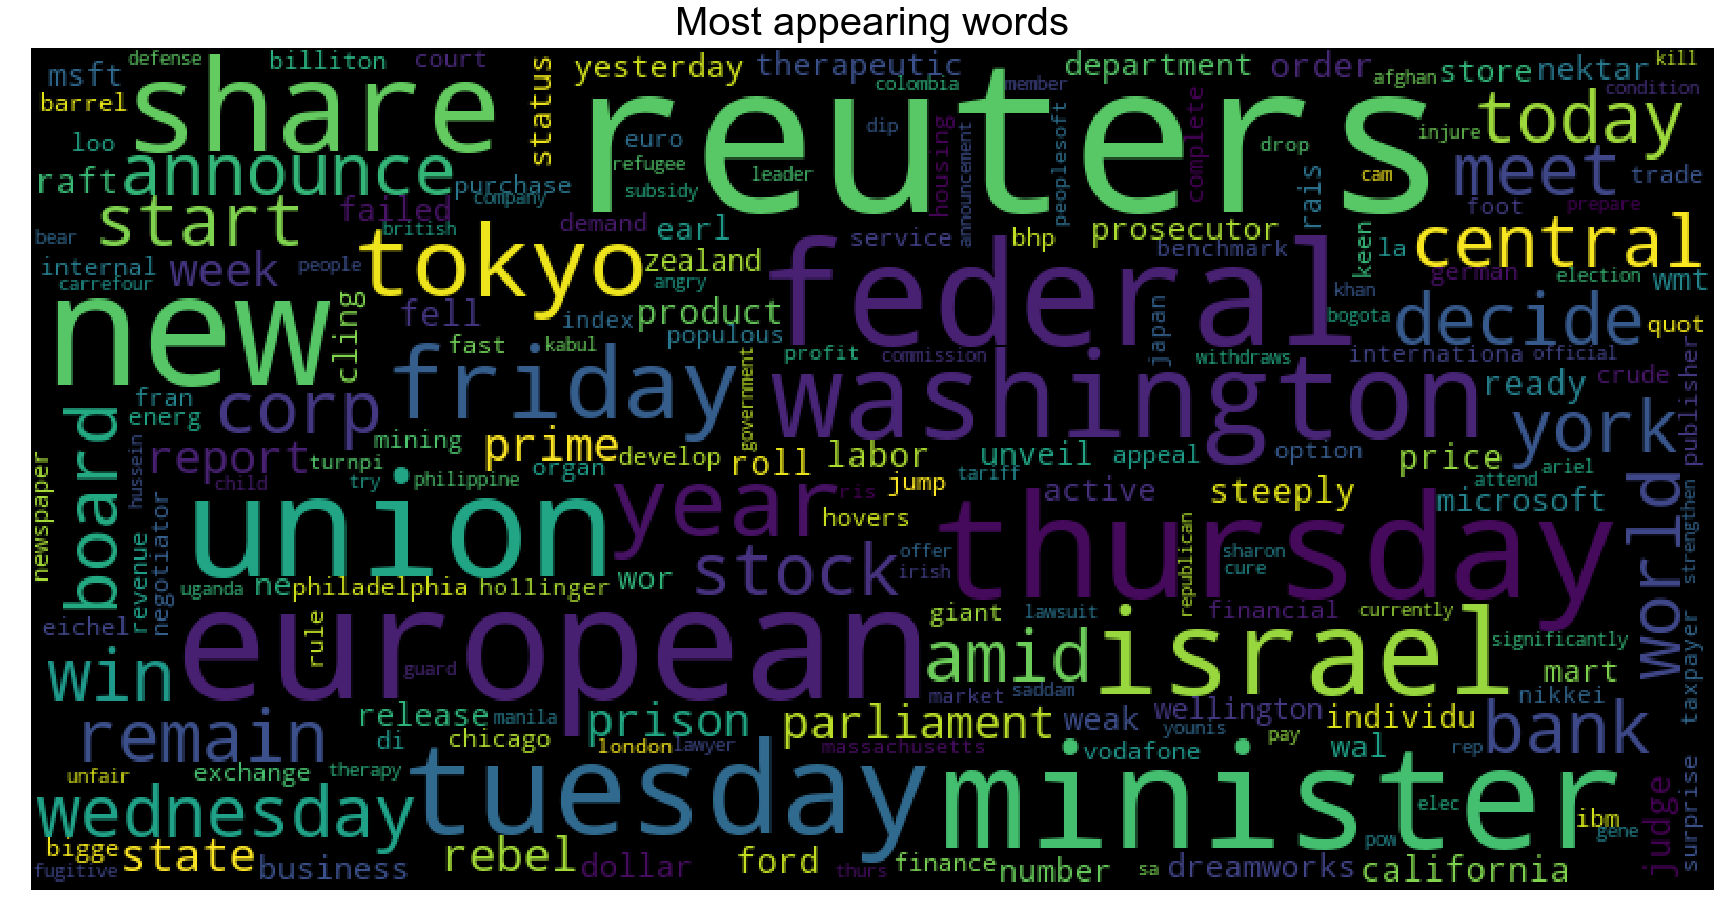

In [20]:
plot_wordcloud(df['clean_text'], title='Most appearing words')

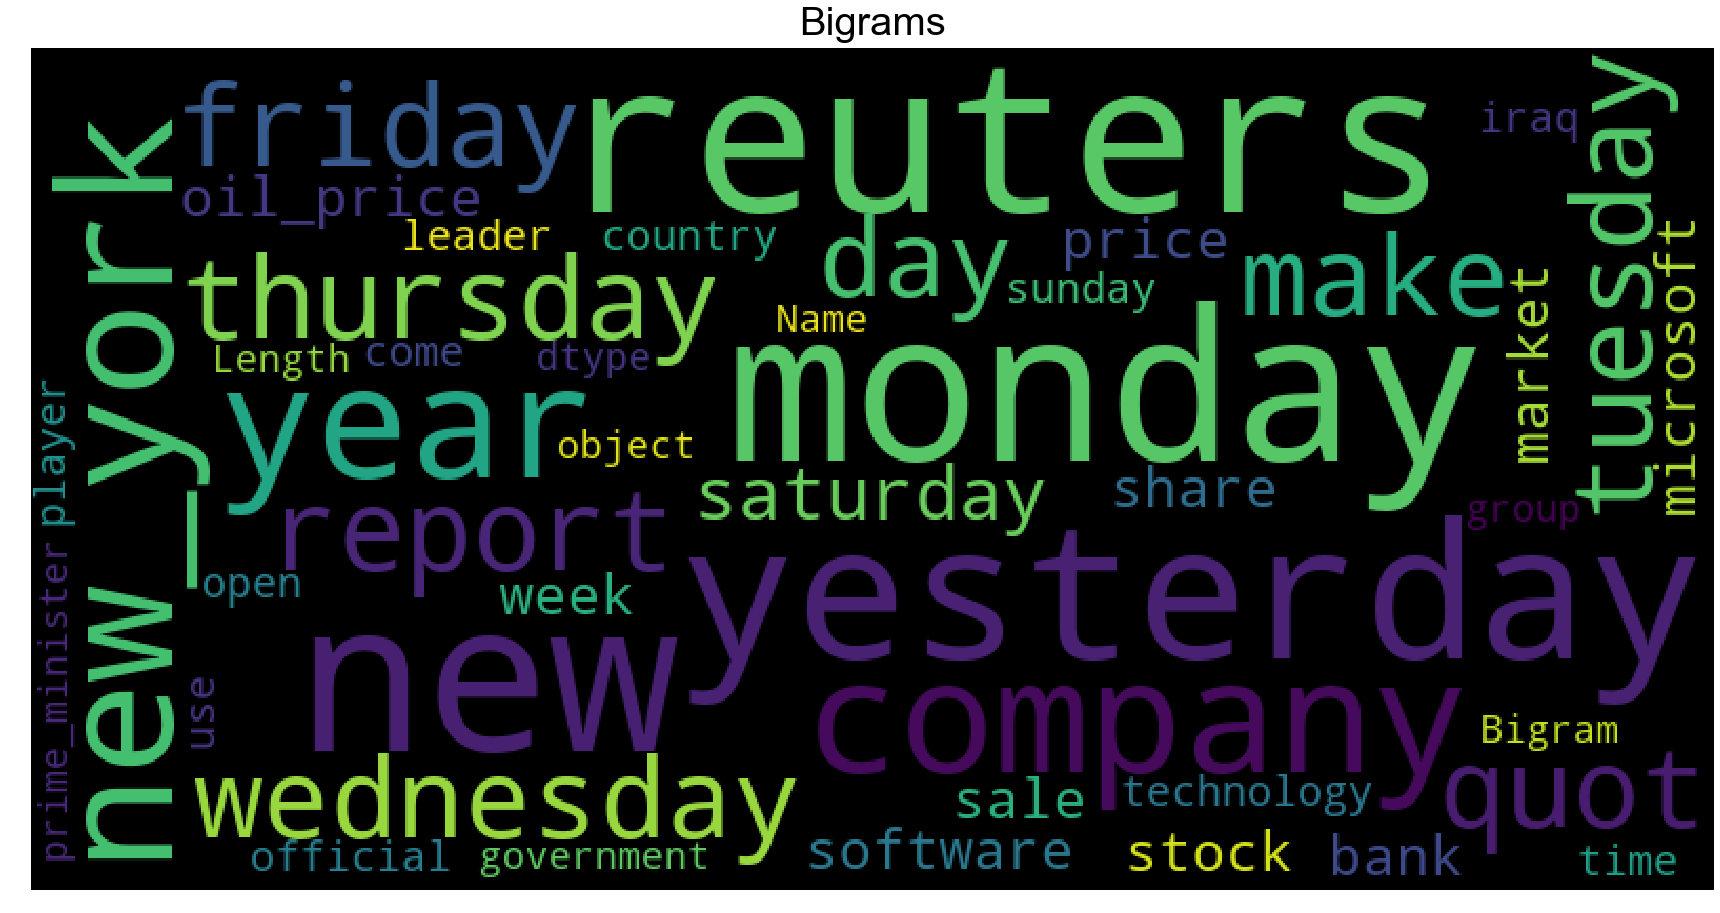

In [21]:
df_wf1.columns = ['Bigram', 'Frequency']
plot_wordcloud(df_wf1['Bigram'], title="Bigrams")

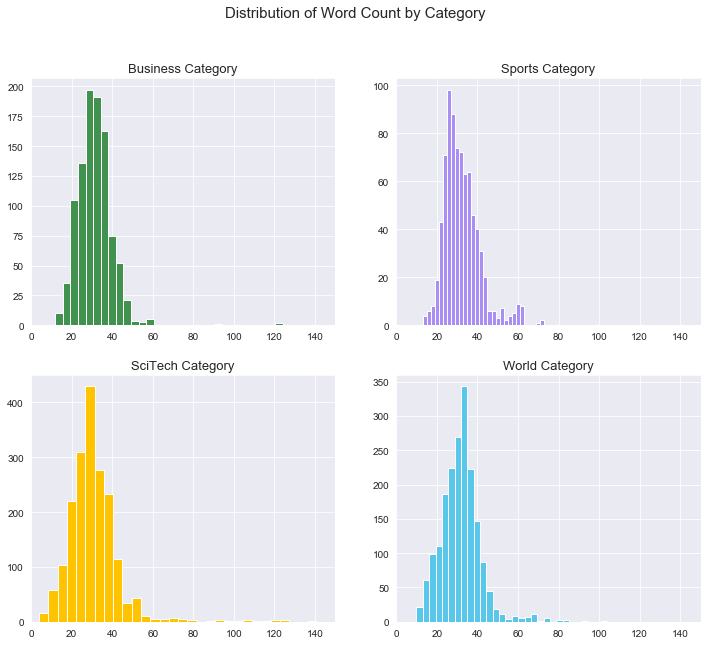

In [22]:
#create dist plots for word count of each record in all categories

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Distribution of Word Count by Category', fontsize=15)

bins = 30

ax[0, 0].hist(df_business['word_count'], bins = bins, color = '#41924F')
ax[0, 0].set_title('Business Category', fontsize = 13)
ax[0, 0].set_xlim(0, 150)

ax[1, 0].hist(df_scitech['word_count'], bins = bins, color = '#FFC300')
ax[1, 0].set_title('SciTech Category', fontsize = 13)
ax[1, 0].set_xlim(0, 150)

ax[0, 1].hist(df_sports['word_count'], bins = bins, color = '#a98ff3')
ax[0, 1].set_title('Sports Category', fontsize = 13)
ax[0, 1].set_xlim(0, 150)

ax[1, 1].hist(df_world['word_count'], bins = bins, color = '#59C7EA')
ax[1, 1].set_title('World Category', fontsize = 13)
ax[1, 1].set_xlim(0, 150)

plt.show()

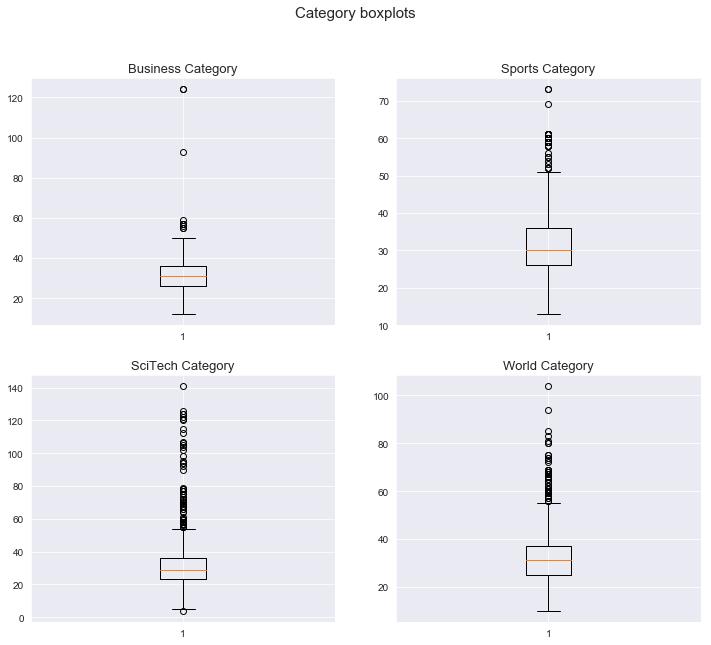

In [23]:
#create boxplots for the word count in all the categories

fig, ax = plt.subplots(2, 2, figsize = (12,10))
fig.suptitle('Category boxplots', fontsize=15)

ax[0, 0].boxplot(df_business['word_count'])
ax[0, 0].set_title('Business Category', fontsize = 13)

ax[1, 0].boxplot(df_scitech['word_count'])
ax[1, 0].set_title('SciTech Category', fontsize = 13)

ax[0, 1].boxplot(df_sports['word_count'])
ax[0, 1].set_title('Sports Category', fontsize = 13)

ax[1, 1].boxplot(df_world['word_count'])
ax[1, 1].set_title('World Category', fontsize = 13)

plt.show()

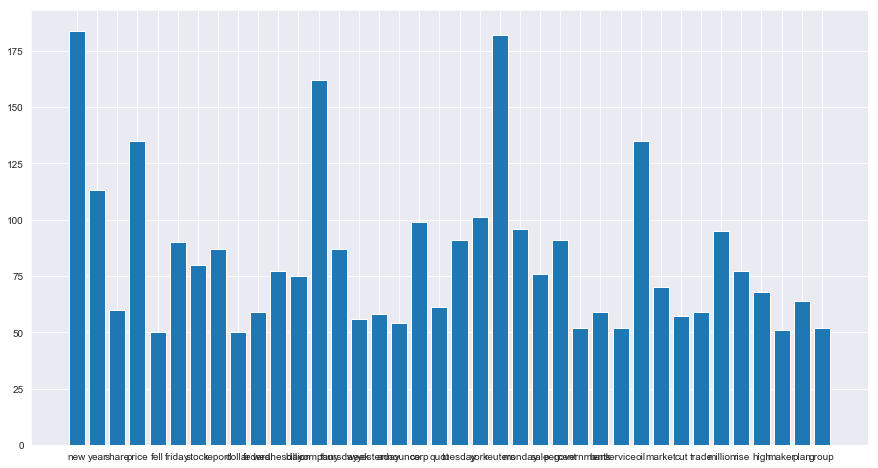

In [24]:
final_list = []
for l in df_business['clean_text']:
    final_list.extend(l)

dict = {}
for word in final_list:
    if not word in dict:
        dict.update({word:1})
    else:
        dict.update({word:int(dict.get(word)+1)})

to_pop = []
for k in dict.keys():
    if dict.get(k) < 50:
        to_pop.append(k)
for i in to_pop:
    dict.pop(i)
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(dict.keys(), dict.values())
plt.show()

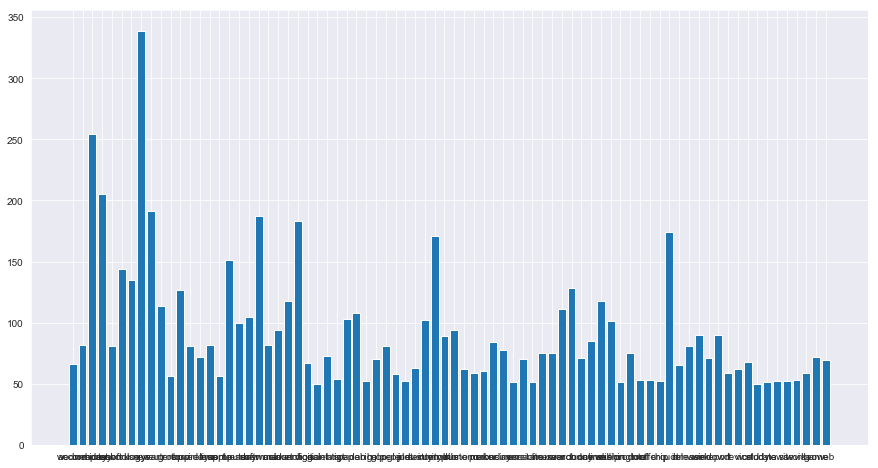

In [25]:
final_list = []
for l in df_scitech['clean_text']:
    final_list.extend(l)

dict = {}
for word in final_list:
    if not word in dict:
        dict.update({word:1})
    else:
        dict.update({word:int(dict.get(word)+1)})

to_pop = []
for k in dict.keys():
    if dict.get(k) < 50:
        to_pop.append(k)
for i in to_pop:
    dict.pop(i)
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(dict.keys(), dict.values())
plt.show()

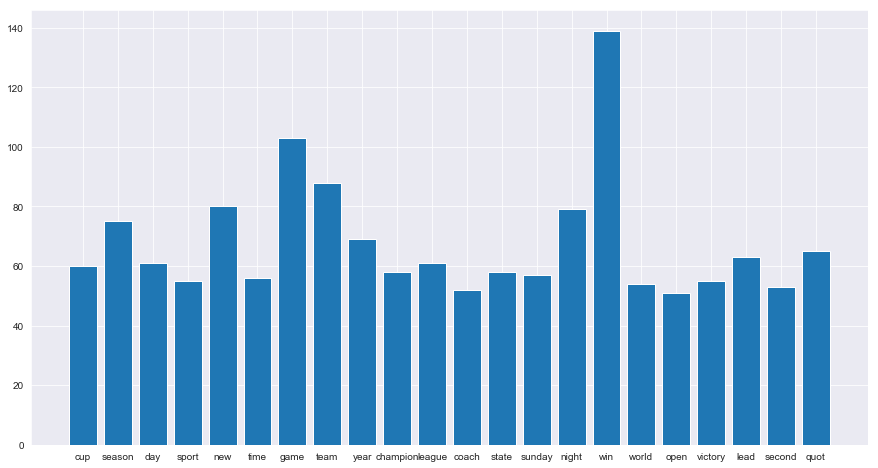

In [26]:
final_list = []
for l in df_sports['clean_text']:
    final_list.extend(l)

dict = {}
for word in final_list:
    if not word in dict:
        dict.update({word:1})
    else:
        dict.update({word:int(dict.get(word)+1)})

to_pop = []
for k in dict.keys():
    if dict.get(k) < 50:
        to_pop.append(k)
for i in to_pop:
    dict.pop(i)
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(dict.keys(), dict.values())
plt.show()

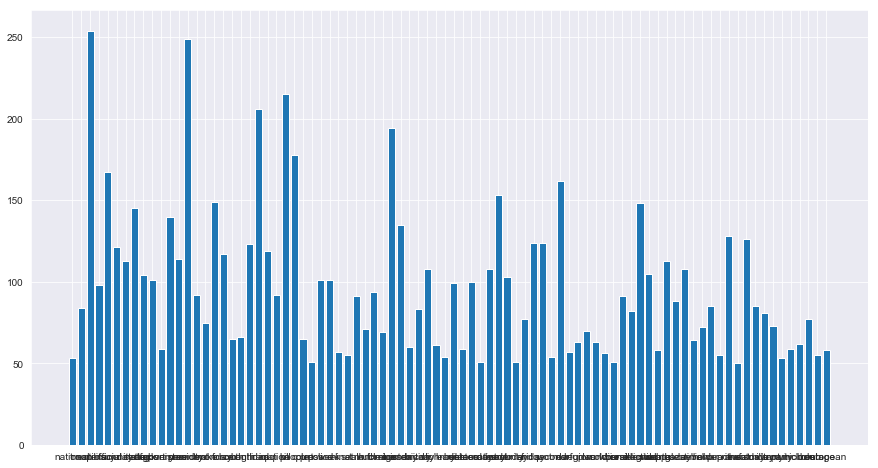

In [27]:
final_list = []
for l in df_world['clean_text']:
    final_list.extend(l)

dict = {}
for word in final_list:
    if not word in dict:
        dict.update({word:1})
    else:
        dict.update({word:int(dict.get(word)+1)})

to_pop = []
for k in dict.keys():
    if dict.get(k) < 50:
        to_pop.append(k)
for i in to_pop:
    dict.pop(i)
plt.rcParams["figure.figsize"] = [15, 8]
plt.bar(dict.keys(), dict.values())
plt.show()

### Setting up for training

In [28]:
le = LabelEncoder()
df['encoded_label'] = le.fit_transform(df['label'])

In [29]:
df['clean_text_join_list'] = df['clean_text'].apply(', '.join)

In [30]:
df.tail()

,content,label,clean_text,word_count,encoded_label,clean_text_join_list
7585,The \$500 billion drug industry is stumbling b...,World,"[billion, drug, industry, stumble, badly, core...",21,3,"billion, drug, industry, stumble, badly, core,..."
7591,"Canadian Press - BANJA LUKA, Bosnia-Herzegovin...",World,"[canadian, press, banja, luka, bosnia-herzegov...",47,3,"canadian, press, banja, luka, bosnia-herzegovi..."
7592,The European Union's decision to hold entry ta...,World,"[european, union's, decision, hold, entry, tal...",14,3,"european, union's, decision, hold, entry, talk..."
7594,WASHINGTON -- Outgoing Secretary of State Coli...,World,"[washington, outgo, secretary, state, colin, l...",49,3,"washington, outgo, secretary, state, colin, l,..."
7595,Ukrainian presidential candidate Viktor Yushch...,World,"[ukrainian, presidential, candidate, viktor, y...",27,3,"ukrainian, presidential, candidate, viktor, yu..."


In [31]:
vectorizer = TfidfVectorizer(min_df= 3, stop_words="english", sublinear_tf=True, norm='l2', ngram_range=(1, 2))
final_features = vectorizer.fit_transform(df['clean_text_join_list'])
final_features.shape

(5590, 8678)

In [32]:
count_vect = CountVectorizer()
X_train_counts = count_vect.fit_transform(df)
X_train_counts.shape

(6, 6)

#### Separating Train and test data

In [33]:
#separate train and test data

X = df['clean_text_join_list']
Y = df['encoded_label']
validation_size = 0.70
seed = 7
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

In [34]:
Tfidf_vect = TfidfVectorizer(max_features=5000)
Tfidf_vect.fit(df['clean_text_join_list'])

Train_X_Tfidf = Tfidf_vect.transform(X_train)
Test_X_Tfidf = Tfidf_vect.transform(X_validation)

### Training

#### SVM

##### Linear SVM

In [35]:
pipeline = Pipeline([('vect', TfidfVectorizer(ngram_range=(1,2), stop_words ='english', sublinear_tf=True)),
                    ('chi', SelectKBest(chi2, k=10000)),
                    ('clf', LinearSVC(C=1.0, penalty='l1', max_iter=3000, dual=False))])

linear_svm_model = pipeline.fit(X_train, Y_train)

In [36]:
svm_vectorizer = linear_svm_model.named_steps['vect']
chi = linear_svm_model.named_steps['chi']
clf = linear_svm_model.named_steps['clf']

In [37]:
feature_names = svm_vectorizer.get_feature_names()
feature_names = [feature_names[i] for i in chi.get_support(indices = True)]
feature_names= np.asarray(feature_names)

In [38]:
target_names = ['Business', 'Sci tech', 'Sports', 'World']
print('Top 10 per class')
for i, label in enumerate(target_names):
    top10 = np.argsort(clf.coef_[i])[-10:]
    print(f'%s : %s' %(label, ' '.join(feature_names[top10])))

Top 10 per class
Business : mgm bankruptcy oil discussion investment painkiller bn york reuters aircraft shareholder
Sci tech : study moon linux version researcher internet software microsoft space scientist
Sports : manchester bryant coach night champion sox season sport football cup
World : darfur election death leader islamic nuclear kill president iraq minister


##### SVM with specific kernel functions

In [39]:
svm_auto = SVC(C=1.0, kernel='linear', gamma='auto')
svm_auto.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [40]:
#1e-2, 1, 1e2

In [41]:
svm_auto_with_gamma_0 = SVC(C=1.0, kernel='linear', gamma=1e-2)
svm_auto_with_gamma_0.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [42]:
svm_auto_with_gamma_0_2 = SVC(C=1.0, kernel='linear', gamma=1e2)
svm_auto_with_gamma_0_2.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [43]:
svm_auto_with_gamma_0_2_cost_100 = SVC(C=100, kernel='linear', gamma=1e2)
svm_auto_with_gamma_0_2_cost_100.fit(Train_X_Tfidf,Y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [44]:
svm_rbf = SVC(C=1.0, kernel='rbf', gamma='auto')
svm_rbf.fit(Train_X_Tfidf, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [45]:
svm_rbf_with_gamma_0 = SVC(C=1.0, kernel='rbf', gamma=1e-2)
svm_rbf_with_gamma_0.fit(Train_X_Tfidf, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [46]:
svm_rbf_with_gamma_0_2 = SVC(C=1.0, kernel='rbf', gamma=1e2)
svm_rbf_with_gamma_0_2.fit(Train_X_Tfidf, Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [47]:
svm_rbf_with_gamma_0_2_cost_100 = SVC(C=100, kernel='rbf', gamma=1e2)
svm_rbf_with_gamma_0_2_cost_100.fit(Train_X_Tfidf, Y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [48]:
svm_poly = SVC(C=1.0, kernel='poly', degree=3, gamma='auto')
svm_poly.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [49]:
svm_poly_with_gamma_0 = SVC(C=1.0, kernel='poly', degree=3, gamma=1e-2)
svm_poly_with_gamma_0.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [50]:
svm_poly_with_gamma_0_2 = SVC(C=1.0, kernel='poly', degree=3, gamma=1e2)
svm_poly_with_gamma_0_2.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [51]:
svm_poly_with_gamma_0_2_cost_100 = SVC(C=100, kernel='poly', degree=3, gamma=1e2)
svm_poly_with_gamma_0_2_cost_100.fit(Train_X_Tfidf,Y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='poly',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [52]:
svm_sigmoid = SVC(C=1.0, kernel='sigmoid', gamma='auto')
svm_sigmoid.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto', kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [53]:
svm_sigmoid_with_gamma_0 = SVC(C=1.0, kernel='sigmoid', gamma=1e-2)
svm_sigmoid_with_gamma_0.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.01, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [54]:
svm_sigmoid_with_gamma_0_2 = SVC(C=1.0, kernel='sigmoid', gamma=1e2)
svm_sigmoid_with_gamma_0_2.fit(Train_X_Tfidf,Y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [55]:
svm_sigmoid_with_gamma_0_2_cost_100 = SVC(C=100, kernel='sigmoid', gamma=1e2)
svm_sigmoid_with_gamma_0_2_cost_100.fit(Train_X_Tfidf,Y_train)

SVC(C=100, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=100.0, kernel='sigmoid',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

#### KNN

In [56]:
knn_model = KNeighborsClassifier(n_neighbors=3)
knn_model.fit(Train_X_Tfidf,Y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=3, p=2,
                     weights='uniform')

#### Naive Bayes

In [57]:
Naive = MultinomialNB()
Naive.fit(Train_X_Tfidf,Y_train)

MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)

#### Logistic

In [58]:
log_reg = LogisticRegression()
log_reg.fit(Train_X_Tfidf,Y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

#### DBSCAN

In [59]:
#plot_clusters(data, cluster.DBSCAN, (), {'eps':0.025})
db = DBSCAN(eps=0.3, min_samples=10).fit(Train_X_Tfidf)
labels = db.labels_

#### KMeans

In [60]:
kmeans_vectorizer = TfidfVectorizer(stop_words='english')
X = kmeans_vectorizer.fit_transform(X_train)

In [61]:
true_k =4
kmeans_model = KMeans(n_clusters=4, init='k-means++', max_iter=100, n_init=1).fit(X)

In [62]:
print("Top terms per cluster:")
order_centroids = kmeans_model.cluster_centers_.argsort()[:, ::-1]
terms = vectorizer.get_feature_names()
for i in range(true_k):
    print(f"Cluster {i}:")
    for ind in order_centroids[i, :5]:
        print(f'{terms[ind]}')
    print('')

Top terms per cluster:
Cluster 0:
churn
lie
price hold
commitment
amit

Cluster 1:
singh golf
new line
extremist
lie
retreat

Cluster 2:
opinion
mp
hard drive
human
methane

Cluster 3:
king norodom
putt
muqtada
martha stewart
samsung



#### LDA

In [63]:
le = LabelEncoder()
X = le.fit_transform(X_train).reshape(-1,1)
#Y = le.fit_transform(Y_train).reshape(-1,1)

vectorizer = TfidfVectorizer(min_df=1)
lda = LinearDiscriminantAnalysis(n_components = 4)
lda.fit(X, Y_train)

LinearDiscriminantAnalysis(n_components=4, priors=None, shrinkage=None,
                           solver='svd', store_covariance=False, tol=0.0001)

In [64]:
X_new = le.fit_transform(X_train)

#### Fuzzy C-Means

In [65]:
fcm = FCM(n_clusters=4)
fcm.fit(X)

# outputs
fcm_centers = fcm.centers
fcm_labels  = fcm.u.argmax(axis=1)

### Testing and evaluation

In [66]:
metrics_columns = ['accuracy', 'precision', 'f1-score', 'recall', 'kappa', 'time']
perf_df = pd.DataFrame(columns=metrics_columns)
perf_df_no_tuning = pd.DataFrame(columns=metrics_columns)

#### SVM

In [67]:
start = time.clock()

y_predicted = svm_auto.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 459,   51,    2,   52],
       [ 181, 1174,   59,   80],
       [   0,   10,  457,   32],
       [  71,   81,   47, 1157]], dtype=int64)

In [68]:
start = time.clock()

y_predicted = svm_auto_with_gamma_0.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 459,   51,    2,   52],
       [ 181, 1174,   59,   80],
       [   0,   10,  457,   32],
       [  71,   81,   47, 1157]], dtype=int64)

In [69]:
start = time.clock()

y_predicted = svm_auto_with_gamma_0_2.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 459,   51,    2,   52],
       [ 181, 1174,   59,   80],
       [   0,   10,  457,   32],
       [  71,   81,   47, 1157]], dtype=int64)

In [70]:
start = time.clock()

y_predicted = svm_auto_with_gamma_0_2_cost_100.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 494,  115,    7,   70],
       [ 135, 1107,   45,   89],
       [   0,   13,  458,   31],
       [  82,   81,   55, 1131]], dtype=int64)

In [71]:
start = time.clock()

y_predicted = svm_rbf.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 711, 1316,  565, 1321],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [72]:
start = time.clock()

y_predicted = svm_rbf_with_gamma_0.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 711, 1316,  565, 1321],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [73]:
start = time.clock()

y_predicted = svm_auto_with_gamma_0_2.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 459,   51,    2,   52],
       [ 181, 1174,   59,   80],
       [   0,   10,  457,   32],
       [  71,   81,   47, 1157]], dtype=int64)

In [74]:
start = time.clock()

y_predicted = svm_auto_with_gamma_0_2_cost_100.predict(Test_X_Tfidf)

stop  = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)


print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 494,  115,    7,   70],
       [ 135, 1107,   45,   89],
       [   0,   13,  458,   31],
       [  82,   81,   55, 1131]], dtype=int64)

In [75]:
start = time.clock()

y_predicted = svm_poly.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 711, 1316,  565, 1321],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [76]:
start = time.clock()

y_predicted = svm_poly_with_gamma_0.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 711, 1316,  565, 1321],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [77]:
start = time.clock()

y_predicted = svm_poly_with_gamma_0_2.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[  96,    1,    0,    0],
       [ 486, 1259,  407,  202],
       [   0,    0,   75,    1],
       [ 129,   56,   83, 1118]], dtype=int64)

In [78]:
start = time.clock()

y_predicted = svm_poly_with_gamma_0_2_cost_100.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[  96,    1,    0,    0],
       [ 486, 1259,  407,  202],
       [   0,    0,   75,    1],
       [ 129,   56,   83, 1118]], dtype=int64)

In [79]:
start = time.clock()

y_predicted = svm_sigmoid.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 711, 1316,  565, 1321],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [80]:
start = time.clock()

y_predicted = svm_sigmoid_with_gamma_0.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 711, 1316,  565, 1321],
       [   0,    0,    0,    0],
       [   0,    0,    0,    0]], dtype=int64)

In [81]:
start = time.clock()

y_predicted = svm_sigmoid_with_gamma_0_2.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[362, 229,  42, 175],
       [234, 937,  91, 154],
       [ 11,  37, 363,  62],
       [104, 113,  69, 930]], dtype=int64)

In [82]:
start = time.clock()

y_predicted = svm_sigmoid_with_gamma_0_2_cost_100.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)


print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[368, 236,  60, 213],
       [203, 897,  90, 121],
       [ 22,  53, 342,  75],
       [118, 130,  73, 912]], dtype=int64)

#### KNN

In [83]:
start = time.clock()

y_predicted = knn_model.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 510,  168,   33,  116],
       [ 134, 1033,   76,  106],
       [   7,   25,  411,   50],
       [  60,   90,   45, 1049]], dtype=int64)

#### Naive Bayes

In [84]:
start = time.clock()

y_predicted = Naive.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 265,   12,    0,   23],
       [ 314, 1200,  122,   74],
       [   0,    0,  283,   19],
       [ 132,  104,  160, 1205]], dtype=int64)

#### Logistic

In [85]:
start = time.clock()

y_predicted = log_reg.predict(Test_X_Tfidf)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[ 326,   18,    0,   28],
       [ 264, 1201,  105,   88],
       [   1,    0,  357,   22],
       [ 120,   97,  103, 1183]], dtype=int64)

#### DBSCAN

In [86]:
#db.predict(Test_X_Tfidf)

start = time.clock()
y_predicted = db.fit_predict(Test_X_Tfidf)
stop = time.clock()
labels = db.labels_

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,  711, 1316,  565, 1321],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0],
       [   0,    0,    0,    0,    0]], dtype=int64)

#### K-Means

In [87]:
#y_predicted_kmeans = kmeans_model.predict(Test_X_Tfidf)
Y = kmeans_vectorizer.transform(X_validation)
start = time.clock()
y_predicted = kmeans_model.predict(Y)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[169, 564,   0,  13],
       [157, 315, 342, 120],
       [361, 428, 204, 933],
       [ 24,   9,  19, 255]], dtype=int64)

#### LDA

In [88]:
#y_predicted_lda = lda.predict(Test_X_Tfidf)
X_val_lda = le.fit_transform(X_validation).reshape(-1,1)

start = time.clock()
y_predicted = lda.predict(X_val_lda)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[   0,    0,    0,    0],
       [ 586, 1084,  424, 1021],
       [   0,    0,    0,    0],
       [ 125,  232,  141,  300]], dtype=int64)

#### Fuzzy C-Means

In [89]:
start = time.clock()

X_test = le.fit_transform(X_validation).reshape(-1,1)
fcm.fit(X_test)
y_predicted = fcm.u.argmax(axis=1)

stop = time.clock()

precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start


temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)
perf_df_no_tuning = pd.concat([perf_df_no_tuning, temp_df], axis=0)

print('\nConfusion matrix')
confusion_matrix(y_predicted, Y_validation)


Confusion matrix


array([[146, 336, 147, 372],
       [152, 281, 163, 340],
       [199, 373, 125, 319],
       [214, 326, 130, 290]], dtype=int64)

In [90]:
from sklearn.datasets.samples_generator import make_blobs
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc, confusion_matrix, cohen_kappa_score
from numpy import linalg as la
import math
import random

class CustomFCM(object):
    
    def __init__(self, number_of_clusters, threshold):
        self.number_of_clusters = number_of_clusters
        self.threshold = threshold
        self.current_membership_matrix = []  # membership matrix
        self.previous_membership_matrix = []  # membership matrix in previous iteration
        self._data = []
        self.centroids = []
        self._fuzzifier = 2
        self._error = 0.01
        self._dimension = 2
        self.sigma = 0.1
        self.l = []
        
    def load_data(self, data):
        #X, y = make_blobs(n_samples=20, centers=self.number_of_clusters, n_features=2,random_state=0)
        X0 = le.fit_transform(data).reshape(-1,1)
        n,m = X0.shape # for generality
        X1 = np.ones((n,1))
        self._data = np.hstack((X0,X1))
        #print(np.mat(Test_X_Tfidf))
        #print(le.fit_transform(X_train).reshape(-1,1))
    
    def return_membership(self):
        return self.current_membership_matrix
    
    def compute_distance(self, a, b):
        #print(f'a is {a} and b is {b} and norm is {la.norm(a-b)}')
        return la.norm(a)-la.norm(b)
        
    def init_membership_matrix(self):
        max_range = int(max(self._data[:, 0]))
        min_range = int(min(self._data[:, 0]))

        for i in range(len(self._data)):
            s = 0.000001
            self.current_membership_matrix.append([])
            self.previous_membership_matrix.append([])
            for j in range(self.number_of_clusters):
                self.current_membership_matrix[i].append(random.uniform(min_range, max_range))
                s += self.current_membership_matrix[i][j]
                self.previous_membership_matrix[i].append(0)
            for j in range(self.number_of_clusters):
                    self.current_membership_matrix[i][j] /= s
        
    def calculate_centroids(self):
        self.centroids.clear()
        for i in range(self.number_of_clusters):
            cluster_center_row = []
            for j in range(self._dimension):
                sum1 = 0
                sum2 = 0
                for k in range(len(self._data)):
                    powered = self.current_membership_matrix[k][i] ** self._fuzzifier
                    sum1 += powered * self._data[k][j]
                    sum2 += powered
                cluster_center_row.append(sum1 / sum2)
            self.centroids.append(cluster_center_row)
        
    def update_membership_matrix(self):
        for i in range(len(self._data)):
            for j in range(self.number_of_clusters):
                self.previous_membership_matrix[i][j] = self.current_membership_matrix[i][j]
                res = 0
                num = self.compute_distance(self._data[i], self.centroids[j])
                for k in range(self.number_of_clusters):
                    den = self.compute_distance(self._data[i], self.centroids[k])
                    res += (num / den) ** (2 / (self._fuzzifier - 1))
                self.current_membership_matrix[i][j] = 1 / res
        
    def declare_result(self):
        return abs(la.norm(self.current_membership_matrix, ord=2) - la.norm(self.previous_membership_matrix, ord=2))
    
    def cluster_algo(self, data):
        self.load_data(data)
        self.init_membership_matrix()
        self.rbf_kernel(self.current_membership_matrix, self.previous_membership_matrix)
        declared = math.inf
        while declared > self.threshold:
            self.calculate_centroids()
            self.update_membership_matrix()
            declared = self.declare_result()
        self.final_list()
        #print(len(self.l))
        #print(self.return_membership())
        return self.l
    
    def rbf_kernel(self, matrix_a, matrix_b):
        trnorms1 = np.mat([(v * np.mat(v).T)[0, 0] for v in matrix_a]).T
        trnorms2 = np.mat([(v * np.mat(v).T)[0, 0] for v in matrix_b]).T
        k1 = trnorms1 * np.mat(np.ones((np.mat(matrix_b).shape[0], 1), dtype=np.float64)).T
        k2 = np.mat(np.ones((np.mat(matrix_a).shape[0], 1), dtype=np.float64)) * trnorms2.T
        k = k1 + k2
        k -= 2 * np.mat(matrix_a * np.mat(matrix_b).T)
        k *= - 1./(2 * np.power(self.sigma, 2))
        return np.exp(k)
    
    def final_list(self):
        for i in range(len(self.current_membership_matrix)):
            self.l.append(self.current_membership_matrix[i].index(max(self.current_membership_matrix[i])))
        return 0

In [91]:
start = time.clock()
fcm = CustomFCM(4, 0.003)
y_predicted = fcm.cluster_algo(data=X_validation)
stop = time.clock()
precision = precision_score(y_predicted, Y_validation, average='micro')
f_one = f1_score(y_predicted, Y_validation, average='micro')
recall = recall_score(y_predicted, Y_validation, average='micro')
accuracy = accuracy_score(y_predicted, Y_validation)
kappa = cohen_kappa_score(y_predicted, Y_validation)
test_time = stop-start

temp_df = pd.DataFrame([accuracy, precision, f_one, recall, kappa, test_time]).T
temp_df.columns = metrics_columns
perf_df = pd.concat([perf_df, temp_df], axis=0)

confusion_matrix(y_predicted, Y_validation)

array([[  1,   3,   3,   8],
       [298, 617, 311, 712],
       [  3,   7,   7,   1],
       [409, 689, 244, 600]], dtype=int64)

In [93]:
#What are we predicting?

#Comparing the performance of different algorithms on text classification

In [94]:
#Interpreting confusion matrix

#The columns are the actual classes, whuile the rows are the predicted classes.
#The main diagobnal represents the number of correclty classified items

In [95]:
print('\n\n****************************    Comparisons    ****************************')

perf_df.set_index([['svm-auto', 'svm auto, g=0', 'svm auto, g=0.2', 'svm auto, g=0.2, c=100', 'svm rbf', 'svm rbf, g=0', 'svm rbf, g=0.2', 'svm rbf, g=0.2, c=100', 'svm poly', 'svm poly, g=0', 'svm poly, g=0.2', 'svm poly, g=0.2, c=100', 'svm sigmoid', 'svm sigmoid, g=0', 'svm sigmoid, g=0.2', 'svm sigmoid, g=0.2, c=100', 'KNN', 'Naive Bayes', 'Logistic', 'DBSCAN', 'K-Means', 'LDA', 'FCM', 'CustomFCM']], inplace=True)
perf_df



****************************    Comparisons    ****************************


,accuracy,precision,f1-score,recall,kappa,time
svm-auto,0.83,0.83,0.83,0.83,0.76,1.29
"svm auto, g=0",0.83,0.83,0.83,0.83,0.76,1.16
"svm auto, g=0.2",0.83,0.83,0.83,0.83,0.76,1.08
"svm auto, g=0.2, c=100",0.82,0.82,0.82,0.82,0.74,1.10
svm rbf,0.34,0.34,0.34,0.34,0.00,1.34
"svm rbf, g=0",0.34,0.34,0.34,0.34,0.00,1.24
"svm rbf, g=0.2",0.83,0.83,0.83,0.83,0.76,0.84
"svm rbf, g=0.2, c=100",0.82,0.82,0.82,0.82,0.74,0.85
svm poly,0.34,0.34,0.34,0.34,0.00,0.99
"svm poly, g=0",0.34,0.34,0.34,0.34,0.00,1.01


In [96]:
print('\n\n****************************    Original    ****************************')

perf_df_no_tuning.set_index([['SVM', 'KNN', 'Naive Bayes', 'Logistic', 'DBSCAN', 'K Means', 'LDA', 'FCM']], inplace=True)
perf_df_no_tuning



****************************    Original    ****************************


,accuracy,precision,f1-score,recall,kappa,time
SVM,0.83,0.83,0.83,0.83,0.76,1.29
KNN,0.77,0.77,0.77,0.77,0.68,0.30
Naive Bayes,0.75,0.75,0.75,0.75,0.64,0.01
Logistic,0.78,0.78,0.78,0.78,0.69,0.00
DBSCAN,0.00,0.00,0.00,0.00,0.00,0.38
K Means,0.24,0.24,0.24,0.24,0.04,0.00
LDA,0.35,0.35,0.35,0.35,0.03,0.00
FCM,0.22,0.22,0.22,0.22,-0.04,0.16
